In [1]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [2]:
%cd /content/drive/MyDrive/Summer2025/MLA_ViT/Yolo Family

/content/drive/MyDrive/Summer2025/MLA_ViT/Yolo Family


In [3]:
import torch.nn as nn
import torch
import cv2
import matplotlib.pyplot as plt
from tqdm import tqdm
import os
import yaml
import gc
import numpy as np
import json
from collections import defaultdict
from torch.utils.data import DataLoader
from PIL import Image

In [4]:
DEVICE = 'cuda' if torch.cuda.is_available() else 'cpu'
print("Device: ", DEVICE)

Device:  cuda


In [5]:
config_path = os.path.join(os.getcwd(), "config/config.yaml")
with open(config_path, "r") as file:
    config = yaml.safe_load(file)


In [6]:



class YOLO(nn.Module):
    def __init__(self, img_w = 448, img_h = 448, S = 7, B = 2, num_classes= 20):
        super().__init__()
        self.img_w = img_w
        self.img_h = img_h
        self.S = S
        self.B = B
        self.num_classes = num_classes

        self.pred_dim  =  self.B * 5 + self.num_classes


        ## mybackbone from figure 3 of the paper
        cnn_backbone_layers = [

            nn.Conv2d(in_channels = 3, out_channels= 64, kernel_size=7,  stride = 2, padding =3),
            self.conv_activations(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(in_channels = 64, out_channels= 192,  kernel_size=3, stride = 1, padding =1),
            self.conv_activations(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            nn.Conv2d(in_channels = 192, out_channels= 128,  kernel_size=1, stride = 1, padding =0),
            self.conv_activations(),
            nn.Conv2d(in_channels = 128, out_channels= 256,  kernel_size=1, stride = 1, padding =0),
            self.conv_activations(),
            nn.Conv2d(in_channels = 256, out_channels= 256,  kernel_size=1, stride = 1, padding =0),
            self.conv_activations(),
            nn.Conv2d(in_channels = 256, out_channels= 512,  kernel_size=3, stride = 1, padding =1),
            self.conv_activations(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            ]

        for _ in range(4):
            cnn_backbone_layers.extend(
                            [nn.Conv2d(in_channels = 512, out_channels= 256,  kernel_size=1, stride = 1, padding =0),
                            self.conv_activations(),
                            nn.Conv2d(in_channels = 256, out_channels= 512,  kernel_size=3, stride = 1, padding =1),
                            self.conv_activations(),

                            ] )



        cnn_backbone_layers.extend(

            [
            nn.Conv2d(in_channels = 512, out_channels= 512,  kernel_size=1, stride = 1, padding =0),
            self.conv_activations(),
            nn.Conv2d(in_channels = 512, out_channels= 1024,  kernel_size=3, stride = 1, padding =1),
            self.conv_activations(),
            nn.MaxPool2d(kernel_size=2, stride=2),


            ]
        )


        for _ in range(2):
            cnn_backbone_layers.extend(

                [
                nn.Conv2d(in_channels = 1024, out_channels= 512,  kernel_size=1, stride = 1, padding =0),
                self.conv_activations(),
                nn.Conv2d(in_channels = 512, out_channels= 1024,  kernel_size=3, stride = 1, padding =1),
                self.conv_activations(),
                ]
            )

        cnn_backbone_layers.extend(

                [
                nn.Conv2d(in_channels = 1024, out_channels= 1024,  kernel_size=3, stride = 1, padding =1),
                self.conv_activations(),
                nn.Conv2d(in_channels = 1024, out_channels= 1024,  kernel_size=3, stride = 2, padding =1),
                self.conv_activations(),
                ]
            )


        cnn_backbone_layers.extend(

                [
                nn.Conv2d(in_channels = 1024, out_channels= 1024,  kernel_size=3, stride = 1, padding =1),
                self.conv_activations(),
                nn.Conv2d(in_channels = 1024, out_channels= 1024,  kernel_size=3, stride = 1, padding =1),
                self.conv_activations(),
                ]
            )
        self.backbone = nn.Sequential(*cnn_backbone_layers)


        #########Flatten, Feedforward Layers ####################

        self.mlp =  nn.Sequential(
            nn.Flatten(),
            nn.Linear(self.S* self.S* 1024, 4096),
            self.conv_activations(),
            nn.Linear(4096, self.S*self.S* self.pred_dim),


        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.mlp(x)
        x = x.reshape(x.shape[0], self.S, self.S, self.pred_dim)
        return x

    def conv_activations(self):
        return nn.LeakyReLU(negative_slope=0.1)


In [7]:


class SmallYOLO(nn.Module):
    def __init__(self, img_w=448, img_h=448, S=7, B=2, num_classes=20):
        super().__init__()
        self.img_w = img_w
        self.img_h = img_h
        self.S = S
        self.B = B
        self.num_classes = num_classes
        self.pred_dim = self.B * 5 + self.num_classes

        self.backbone = nn.Sequential(
            nn.Conv2d(3, 32, kernel_size=7, stride=2, padding=3),
            self.conv_activations(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(32, 64, kernel_size=3, stride=1, padding=1),
            self.conv_activations(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(64, 128, kernel_size=3, stride=1, padding=1),
            self.conv_activations(),
            nn.Conv2d(128, 256, kernel_size=3, stride=1, padding=1),
            self.conv_activations(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(256, 512, kernel_size=3, stride=1, padding=1),
            self.conv_activations(),
            nn.MaxPool2d(kernel_size=2, stride=2),

            nn.Conv2d(512, 256, kernel_size=3, stride=1, padding=1),
            self.conv_activations(),
            nn.Conv2d(256, 256, kernel_size=3, stride=2, padding=1),
            self.conv_activations(),
        )

        self.mlp = nn.Sequential(
            nn.Flatten(),
            nn.Linear((self.S * self.S * 256), 1024),
            self.conv_activations(),
            nn.Linear(1024, self.S * self.S * self.pred_dim),
        )

    def forward(self, x):
        x = self.backbone(x)
        x = self.mlp(x)
        x = x.reshape(x.shape[0], self.S, self.S, self.pred_dim)
        return x

    def conv_activations(self):
        return nn.LeakyReLU(negative_slope=0.1)


In [8]:
inp = torch.randn((4, 3, 448, 448))
model = SmallYOLO()
model(inp).shape

torch.Size([4, 7, 7, 30])

How to Download Data

In [9]:
# !pip install roboflow

# from roboflow import Roboflow
# rf = Roboflow(api_key="k7db5dkOnUu1oLFMzXvB")
# project = rf.workspace("roboflow-gw7yv").project("self-driving-car")
# version = project.version(3)
# dataset = version.download("coco")

In [10]:
class MyObjectDetectionDataloader:

    def __init__(self, image_dir="../Self-Driving-Car-3/export", annt_file = "../Self-Driving-Car-3/export/_annotations.coco.json", train_transforms= None, img_w=512, img_h=512,S = 7,B=2 ):

        self.train_transforms =  train_transforms
        self.image_dir = image_dir
        self.annt_file =  annt_file
        self.img_w   = 512
        self.img_h = 512
        self.model_img_w = 448
        self.model_img_h = 448
        self.scale_factor = self.model_img_w /self.img_w
        self.S = S
        self.B  = B
        self.grid_size =  self.model_img_h/self.S


        with open(self.annt_file , "r") as f:
            self.annot_data = json.loads(f.read())

        self.class_idx_to_name = {cat['id']: cat['name'] for i, cat in enumerate(self.annot_data["categories"])}
        self.image_id_to_labels = defaultdict(list)
        for annotation in self.annot_data["annotations"]:
            self.image_id_to_labels[annotation["image_id"]].append(annotation)
        self.C = len(self.class_idx_to_name)  # Number of classes



    def __getitem__(self, idx):
        image_name = self.annot_data["images"][idx]['file_name']
        image_id = self.annot_data["images"][idx]['id']

        img_path = os.path.join(self.image_dir, image_name)
        image = Image.open(img_path).convert('RGB')
        if image.size!= (448, 448):
            image = image.resize((448, 448))

        labels = []
        boxes = []


        for item in self.image_id_to_labels[image_id]:
            x, y, w, h = item['bbox']
            # Scale to model size
            x = x * self.scale_factor
            y = y * self.scale_factor
            w = w * self.scale_factor
            h = h * self.scale_factor

            # boxes.append([  (x *self.scale_factor )/self.model_img_w, (y *self.scale_factor )/self.model_img_h, ((x + w) *self.scale_factor) /self.model_img_w,  ((y + h) *self.scale_factor)/self.model_img_h])
            boxes.append([  x, y, (x + w), (y + h)])


            labels.append([item['category_id']])

        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        labels = torch.as_tensor(labels, dtype=torch.int64)

        if self.train_transforms:
            image = self.train_transforms(image)

        target = self.convert_to_yolo_target(boxes, labels)
        output_target  = {}
        # output_target['yolo_target'] = target

        output_target['boxes'] = boxes
        output_target['labels'] = labels

        return image, output_target, target


    def __len__(self):
        return len(self.annot_data["images"][:10000])
        pass

    def convert_to_yolo_target(self, boxes, labels):


        target = torch.zeros((self.S, self.S, self.B*5 + self.C))

        for box, label in zip(boxes, labels):
            grids, box = self.box_cord_to_yolo(box)
            grid_x, grid_y  = grids
            for b in range(self.B):
                target[grid_x, grid_y, b*5 : b*5+4] = torch.tensor(box)
                target[grid_x, grid_y, b*5+4] = 1  # Confidence
            # Set class probability (one-hot encoding)
            target[grid_x, grid_y, self.B*5 + label] = 1
        return target


    def box_cord_to_yolo(self, box):
        x1, y1, x2, y2 = box
        cx = (x1 + x2) / 2
        cy = (y1 + y2) / 2
        w = (x2 - x1) / self.model_img_w
        h = (y2 - y1) / self.model_img_h

        grid_x_index = int(cx / self.grid_size)
        grid_y_index = int(cy / self.grid_size)

        # Offset of center within the grid cell (between 0 and 1)
        cx_grid = (cx % self.grid_size) / self.grid_size
        cy_grid = (cy % self.grid_size) / self.grid_size

        return (grid_x_index, grid_y_index), [cx_grid, cy_grid, w, h]

def collate_fn(batch):

    batch_image = torch.tensor([np.array(item[0]) for item in batch]) /255 ## if image is not normalized
    batch_image = batch_image.permute(0,3, 1, 2)
    targets = [item[1] for item in batch]
    yolo_targets = torch.stack([item[2] for item in batch])
    return batch_image, targets, yolo_targets


def yolo_to_box_cord(grid, box, cell_size_x=64,cell_size_y=64, model_img_h=448):
    """
    grid:   (grid_x_index, grid_y_index)  — which cell the object lives in
    box:    [cx_cell, cy_cell, w_pixels, h_pixels]
            where cx_cell,cy_cell ∈ [0,1) are offsets within that cell,
            and w_pixels,h_pixels are in the same pixel‐units as mode/l_img_w/model_img_h
    returns: [x1, y1, x2, y2] in absolute pixel coords on the model‐resized image
    """
    # print("box->",box, grid)
    grid_x, grid_y = grid
    cx_cell, cy_cell, w_pix, h_pix = box
    w_pix = w_pix*model_img_h
    h_pix = h_pix*model_img_h



    # reconstruct centre in absolute pixels
    cx = grid_x * cell_size_x + (cx_cell * cell_size_x)
    cy = grid_y * cell_size_y + (cy_cell * cell_size_y)

    # recover corners
    x1 = cx - (w_pix  / 2)
    y1 = cy - (h_pix  / 2)
    x2 = x1 + w_pix
    y2 = y1 + h_pix

    return [x1, y1, x2, y2]

test dataloader


In [11]:

train_data = MyObjectDetectionDataloader()
train_loader = DataLoader(dataset= train_data, batch_size=config["BATCH_SIZE"], shuffle=True,collate_fn=collate_fn)
print("lentrain data",len(train_data))
for images, orig_box, yolo_labels in train_loader:
    print("batch image shape->",images.shape)
    print("box labels original->",orig_box)
    print("yolo labels shape->",yolo_labels.shape)
    break

lentrain data 10000


<ipython-input-10-e926b9ce7a99>:110: UserWarning: Creating a tensor from a list of numpy.ndarrays is extremely slow. Please consider converting the list to a single numpy.ndarray with numpy.array() before converting to a tensor. (Triggered internally at /pytorch/torch/csrc/utils/tensor_new.cpp:254.)
  batch_image = torch.tensor([np.array(item[0]) for item in batch]) /255 ## if image is not normalized


batch image shape-> torch.Size([64, 3, 448, 448])
box labels original-> [{'boxes': tensor([[  0.8750, 173.2500,  23.6250, 250.6875],
        [ 12.2500, 203.0000,  68.6875, 247.1875],
        [ 14.0000, 201.2500,  68.6875, 243.2500],
        [ 66.5000, 204.7500, 110.2500, 239.3125],
        [102.3750, 205.6250, 161.4375, 265.5625],
        [205.6250, 213.5000, 232.7500, 248.5000],
        [266.0000, 209.1250, 273.8750, 240.6250]]), 'labels': tensor([[11],
        [11],
        [11],
        [11],
        [ 2],
        [ 2],
        [ 3]])}, {'boxes': tensor([[ 80.5000, 226.6250,  87.0625, 263.8125],
        [ 67.3750, 224.8750,  78.7500, 267.3125],
        [ 28.0000, 230.1250,  38.9375, 267.7500],
        [ 81.3750, 210.0000, 143.0625, 254.6250],
        [111.1250, 227.5000, 119.8750, 264.2500],
        [303.6250, 219.6250, 337.7500, 251.5625],
        [329.0000, 222.2500, 349.1250, 236.2500]]), 'labels': tensor([[ 3],
        [ 3],
        [ 3],
        [11],
        [ 3],
        [ 2]

torch.Size([7, 7, 22])
(14, 201) (68, 243)
(14, 201) (68, 243)
(66, 204) (110, 239)
(66, 204) (110, 239)
(102, 205) (161, 265)
(102, 205) (161, 265)
(205, 213) (232, 248)
(205, 213) (232, 248)
(266, 209) (273, 240)
(266, 209) (273, 240)


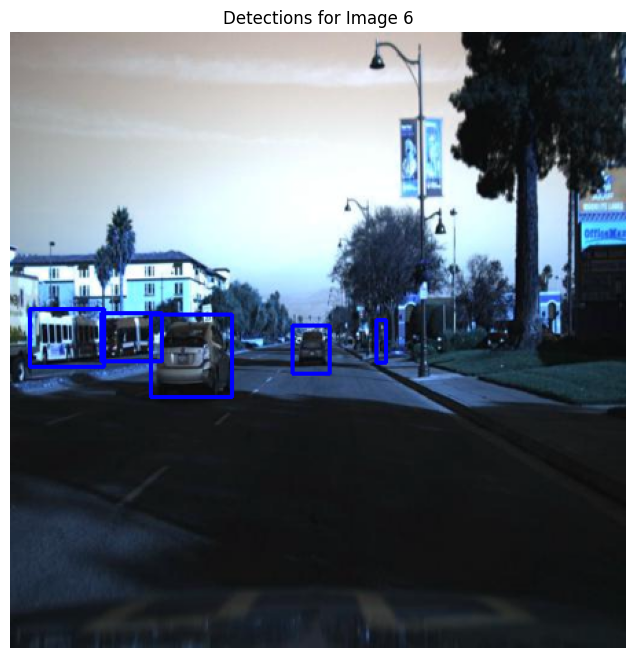

In [12]:
########Test Yolo Label######################
conf_threshold = 0.5
for i, box in enumerate(orig_box):
    if len(box["boxes"]):
        # shape (7,7,22)
        preds = yolo_labels[i]
        image =     np.array(images[i].permute(1,2,0))
        orig = orig_box[i]["boxes"]
        print(preds.shape)



        cell_w = train_data.model_img_w / train_data.S   # e.g. 448/7 = 64 px
        cell_h = train_data.model_img_h / train_data.S
        detections = []
        for i in range(train_data.S):                # grid_x index
            for j in range(train_data.S):              # grid_y index
                cell_pred = preds[i,j]        # length = B*5 + C
                # for each box‐predictor
                for b in range(train_data.B):
                    # extract the 5 values: [x_off, y_off, w, h, conf] b*5 : b*5+4 #[grid_y, grid_x, self.B*5 + label]
                    x_off, y_off, w_pix_norm, h_pix_norm, conf = cell_pred[b*5:(b*5)+5]
                    if conf > conf_threshold:
                        # this box “exists” — use grid=(j,i) and box=[x_off, y_off, w_pix, h_pix]
                        corners = yolo_to_box_cord((i,j), [x_off, y_off, w_pix_norm, h_pix_norm])
                        detections.append((corners, conf, preds[i,j][train_data.B*5:]))

        # --- Draw detections ---
        for (x1, y1, x2, y2), conf, class_probs in detections:
            class_id = torch.argmax(class_probs).item()
            class_score = class_probs[class_id].item()
            label = f"{class_id}:{class_score:.2f}"
            print( (int(x1), int(y1)), (int(x2), int(y2)))
            # Draw rectangle
            cv2.rectangle(image, (int(x1), int(y1)), (int(x2), int(y2)), (255, 0, 0), 2)
            # Put label
            # cv2.putText(image, label, (int(x1), int(y1)-5),
            #             cv2.FONT_HERSHEY_SIMPLEX, 0.5, (255, 0, 0), 1)

        # --- Display image ---
        plt.figure(figsize=(8, 8))
        plt.imshow(cv2.cvtColor(image, cv2.COLOR_BGR2RGB))
        plt.axis('off')
        plt.title(f"Detections for Image {i}")
        plt.show()
        break


In [13]:


def intersection_over_union(boxes_preds, boxes_labels, box_format="midpoint", eps=1e-6):
    """
    Calculates intersection over union (IoU) between predicted and target bounding boxes.

    Parameters:
    - boxes_preds (tensor): Predictions of bounding boxes (BATCH_SIZE, S, S, 4)
    - boxes_labels (tensor): Correct labels of bounding boxes (BATCH_SIZE, S, S, 4)
    - box_format (str): "midpoint" or "corners", format of boxes
    - eps (float): Small value to prevent division by zero

    Returns:
    - tensor: IoU for each corresponding prediction and target
    """

    if box_format == "midpoint":
        # Convert [x, y, w, h] to [x1, y1, x2, y2]
        box1_x1 = boxes_preds[..., 0:1] - boxes_preds[..., 2:3] / 2
        box1_y1 = boxes_preds[..., 1:2] - boxes_preds[..., 3:4] / 2
        box1_x2 = boxes_preds[..., 0:1] + boxes_preds[..., 2:3] / 2
        box1_y2 = boxes_preds[..., 1:2] + boxes_preds[..., 3:4] / 2
        box2_x1 = boxes_labels[..., 0:1] - boxes_labels[..., 2:3] / 2
        box2_y1 = boxes_labels[..., 1:2] - boxes_labels[..., 3:4] / 2
        box2_x2 = boxes_labels[..., 0:1] + boxes_labels[..., 2:3] / 2
        box2_y2 = boxes_labels[..., 1:2] + boxes_labels[..., 3:4] / 2

    elif box_format == "corners":
        # Assume input is already [x1, y1, x2, y2]
        box1_x1, box1_y1, box1_x2, box1_y2 = boxes_preds[..., 0:1], boxes_preds[..., 1:2], boxes_preds[..., 2:3], boxes_preds[..., 3:4]
        box2_x1, box2_y1, box2_x2, box2_y2 = boxes_labels[..., 0:1], boxes_labels[..., 1:2], boxes_labels[..., 2:3], boxes_labels[..., 3:4]

    # Intersection coordinates
    x1 = torch.max(box1_x1, box2_x1)
    y1 = torch.max(box1_y1, box2_y1)
    x2 = torch.min(box1_x2, box2_x2)
    y2 = torch.min(box1_y2, box2_y2)

    # Clamp to avoid negative values
    intersection = (x2 - x1).clamp(0) * (y2 - y1).clamp(0)

    # Areas
    box1_area = abs((box1_x2 - box1_x1) * (box1_y2 - box1_y1))
    box2_area = abs((box2_x2 - box2_x1) * (box2_y2 - box2_y1))

    union = box1_area + box2_area - intersection + eps

    return intersection / union


Loss function

In [14]:
class YoloLoss(nn.Module):
    """
    Calculate the loss for yolo (v1) model
    """

    def __init__(self, S=7, B=2, C=3):  # Set C according to your dataset
        super(YoloLoss, self).__init__()
        self.mse = nn.MSELoss(reduction="sum")

        self.S = S
        self.B = B
        self.C = C

        self.lambda_noobj = 0.5
        self.lambda_coord = 5

    def forward(self, predictions, target):
        # Reshape predictions to (batch_size, S, S, B*5 + C)
        predictions = predictions.reshape(-1, self.S, self.S, self.B * 5 + self.C)

        # Calculate IoU for the two predicted bounding boxes with target bbox
        iou_b1 = intersection_over_union(predictions[..., 0:4], target[..., 0:4])  # First box coordinates
        iou_b2 = intersection_over_union(predictions[..., 5:9], target[..., 0:4])  # Second box coordinates
        ious = torch.cat([iou_b1.unsqueeze(0), iou_b2.unsqueeze(0)], dim=0)
        iou_maxes, bestbox = torch.max(ious, dim=0)
        exists_box = target[..., 4].unsqueeze(-1)  # Use first box's confidence (B=0)

        # ======================== #
        #   FOR BOX COORDINATES    #
        # ======================== #
        box_predictions = exists_box * (
            bestbox * predictions[..., 5:9] + (1 - bestbox) * predictions[..., 0:4]
        )
        box_targets = exists_box * target[..., 0:4]

        # Take sqrt of width and height
        box_predictions[..., 2:4] = torch.sign(box_predictions[..., 2:4]) * torch.sqrt(
            torch.abs(box_predictions[..., 2:4] + 1e-6)
        )
        box_targets[..., 2:4] = torch.sqrt(box_targets[..., 2:4])

        box_loss = self.mse(
            torch.flatten(box_predictions, end_dim=-2),
            torch.flatten(box_targets, end_dim=-2),
        )

        # ==================== #
        #   FOR OBJECT LOSS    #
        # ==================== #
        pred_box = (
            bestbox * predictions[..., 9:10] + (1 - bestbox) * predictions[..., 4:5]
        )
        object_loss = self.mse(
            torch.flatten(exists_box * pred_box),
            torch.flatten(exists_box * target[..., 4:5]),
        )

        # ======================= #
        #   FOR NO OBJECT LOSS    #
        # ======================= #
        no_object_loss = self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 4:5], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 4:5], start_dim=1),
        )
        no_object_loss += self.mse(
            torch.flatten((1 - exists_box) * predictions[..., 9:10], start_dim=1),
            torch.flatten((1 - exists_box) * target[..., 4:5], start_dim=1)
        )

        # ================== #
        #   FOR CLASS LOSS   #
        # ================== #
        class_loss = self.mse(
            torch.flatten(exists_box * predictions[..., self.B*5 : self.B*5 + self.C], end_dim=-2),
            torch.flatten(exists_box * target[..., self.B*5 : self.B*5 + self.C], end_dim=-2),
        )

        loss = (
            self.lambda_coord * box_loss
            + object_loss
            + self.lambda_noobj * no_object_loss
            + class_loss
        )

        return loss

Visualize Data

In [15]:
#check model size
def num_parameters(mode):
    total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
    return total_params / 1E6
model = SmallYOLO(num_classes=12)
para = num_parameters(model)
print("#"*10)
print(f"Model Trainable Parameters:\n {para}")
print("#"*10)

##########
Model Trainable Parameters:
 17.29343
##########


Forward Pass Test

In [16]:
model = SmallYOLO(num_classes=12).to(DEVICE)
loss_fn = YoloLoss(S=7, B=2, C=train_data.C)  # Use actual number of classes from your dataset
for images, orig_box, yolo_labels in train_loader:
    print(images.shape)
    images = images.to(DEVICE)
    outputs = model(images)
    yolo_labels = yolo_labels.to(DEVICE)
    print(outputs.shape)
    loss = loss_fn(outputs,yolo_labels )
    print(loss)
    break

torch.Size([64, 3, 448, 448])
torch.Size([64, 7, 7, 22])
tensor(2033.9380, device='cuda:0', grad_fn=<AddBackward0>)


##loss computation as per paper

Making the model's prediction with respect to each grid cell seems to help it atleast localize the object to be within that grid

Else it will be penalized very heavily.

test loss

Train Loop

In [17]:
from tqdm import tqdm


def train(model, dataloader, optimizer, loss_fn, device=DEVICE):
    model.train()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Train', ncols=5)
    total_loss = 0
    avg_ious = 0

    for i, (batch_image, _, targets) in enumerate(dataloader):
        batch_image = batch_image.to(device)
        targets = targets.to(device)

        optimizer.zero_grad()

        with torch.cuda.amp.autocast():
            predictions = model(batch_image)
            loss = loss_fn(predictions, targets)

            # Manually compute IoU for monitoring
            pred_boxes = predictions.reshape(-1, loss_fn.S, loss_fn.S, loss_fn.B * 5 + loss_fn.C)
            target_boxes = targets.reshape(-1, loss_fn.S, loss_fn.S, loss_fn.B * 5 + loss_fn.C)

            iou_b1 = intersection_over_union(pred_boxes[..., 0:4], target_boxes[..., 0:4])  # First box
            iou_b2 = intersection_over_union(pred_boxes[..., 5:9], target_boxes[..., 0:4])  # Second box
            iou_max = torch.max(iou_b1, iou_b2)

            avg_iou = iou_max.mean()

        total_loss += loss.item()
        avg_ious += avg_iou.item()

        batch_bar.set_postfix(
            loss="{:.04f}".format(total_loss / (i + 1)),
            avg_ious="{:.06f}".format(avg_ious / (i + 1)),
            lr="{:.04f}".format(optimizer.param_groups[0]['lr'])
        )

        scaler.scale(loss).backward()
        scaler.step(optimizer)
        scaler.update()

        batch_bar.update()

    batch_bar.close()

    total_loss = float(total_loss / len(dataloader))

    return total_loss


In [18]:
def validation(model, dataloader, loss_fn, device=DEVICE):
    model.eval()

    batch_bar = tqdm(total=len(dataloader), dynamic_ncols=True, leave=False, position=0, desc='Val', ncols=5)
    total_loss = 0
    avg_ious = 0

    with torch.no_grad():  # No gradients needed
        for i, (batch_image,_, targets) in enumerate(dataloader):
            batch_image = batch_image.to(device)
            targets = targets.to(device)

            predictions = model(batch_image)
            loss = loss_fn(predictions, targets)

            # Compute IoUs for logging
            pred_boxes = predictions.reshape(-1, loss_fn.S, loss_fn.S, loss_fn.B * 5 + loss_fn.C)
            target_boxes = targets.reshape(-1, loss_fn.S, loss_fn.S, loss_fn.B * 5 + loss_fn.C)

            iou_b1 = intersection_over_union(pred_boxes[..., 0:4], target_boxes[..., 0:4])
            iou_b2 = intersection_over_union(pred_boxes[..., 5:9], target_boxes[..., 0:4])
            iou_max = torch.max(iou_b1, iou_b2)

            avg_iou = iou_max.mean()

            total_loss += loss.item()
            avg_ious += avg_iou.item()

            batch_bar.set_postfix(
                loss="{:.04f}".format(total_loss / (i + 1)),
                avg_ious="{:.04f}".format(avg_ious / (i + 1)),
            )

            batch_bar.update()

    batch_bar.close()

    total_loss = float(total_loss / len(dataloader))
    return total_loss


In [ ]:

import gc
import torch

torch.cuda.empty_cache()
gc.collect()  # Helps avoid CUDA OOM errors

scaler = torch.cuda.amp.GradScaler()

model = SmallYOLO(num_classes=12).to(DEVICE)
optimizer = torch.optim.AdamW(model.parameters(), lr=config['LR'])

loss_fn = YoloLoss(S=7, B=2, C=12).to(DEVICE)  # Make sure C matches your dataset

for epoch in range(1, config['EPOCHS'] + 1):

    curr_lr = float(optimizer.param_groups[0]['lr'])

    # Train for one epoch
    train_loss = train(model, train_loader, optimizer, loss_fn, DEVICE)

    print(f"Epoch {epoch}/{config['EPOCHS']}\n\t Train Loss: {train_loss:.4f}\t Learning Rate: {curr_lr:.4f}")

    # Evaluate on validation set
    # val_loss = validation(model, val_loader, loss_fn)

    # print(f"Epoch {epoch}/{config['EPOCHS']}\n\t Val Loss: {val_loss:.4f}\t Learning Rate: {curr_lr:.4f}")


<ipython-input-19-e0b1ddfefa76>:7: FutureWarning: `torch.cuda.amp.GradScaler(args...)` is deprecated. Please use `torch.amp.GradScaler('cuda', args...)` instead.
  scaler = torch.cuda.amp.GradScaler()
Train:   0%|          | 0/157 [00:00<?, ?it/s]<ipython-input-17-7c3fcd5147db>:17: FutureWarning: `torch.cuda.amp.autocast(args...)` is deprecated. Please use `torch.amp.autocast('cuda', args...)` instead.
  with torch.cuda.amp.autocast():
Train:  38%|███▊      | 59/157 [48:38<1:21:17, 49.77s/it, avg_ious=0.000751, loss=949.5759, lr=0.0001]

In [ ]:
config["BATCH_SIZE"]

In [ ]:
print("Epoch {}/{} \n\t Train Loss (Classification) {:.04f}\t Learning Rate {:.04f}".format(
        epoch + 1, config['EPOCHS'], train_loss, curr_lr))

In [ ]:
import  math
math.floor(447/64)